In [1]:
import sys
sys.path.append("../") # go to parent dir

%load_ext autoreload
%autoreload 2

In [2]:
from evrp.utils.utilities import create_optimal_edges, create_json_out, update_instance_json, read_instance_json_str, convert_txt_instances_to_csv
from evrp.utils.plot import plot_interactive_graph, plot_evrptwv2g
from evrp.milp.evrptw import EVRPTW

import pandas as pd
import numpy as np

import json

pd.options.plotting.backend = "plotly"

# Convert Schneider instance to E-VRP-TW-V2G

In [35]:
schneider_instance = 'c101C10'
convert_txt_instances_to_csv(schneider_instance)

 # Full solve

Objective options: {Schneider} OR {OpEx CapEx Cycle EA DCM Delivery}

Constraint options: {Start=End FullStart=End NoXkappaBounds NoMinVehicles NoSymmetry NoXd}

In [36]:
instance = 'c101C10_'
fpath = 'config/test_instances/' + instance + '.csv'

In [61]:
m = EVRPTW(problem_type='Schneider Cycle')
m.full_solve(fpath)

2021-03-17 02:38:11 INFO     Building abstract model
2021-03-17 02:38:11 INFO     Defining parameters and sets
2021-03-17 02:38:11 INFO     Defining variables
2021-03-17 02:38:11 INFO     Defining constraints
2021-03-17 02:38:11 INFO     Importing EVRPTW MILP instance: c101C10_
2021-03-17 02:38:11 INFO     Reading CSV
2021-03-17 02:38:11 INFO     Creating graph
2021-03-17 02:38:11 INFO     Creating timeseries data
2021-03-17 02:38:11 INFO     Creating duplicates and extended graph
2021-03-17 02:38:11 INFO     Using Scipy euclidian distances to generate distance matrix
2021-03-17 02:38:11 INFO     Calculating distance matrix
2021-03-17 02:38:11 INFO     Creating parameters
2021-03-17 02:38:11 INFO     Creating instance
2021-03-17 02:38:14 INFO     Problem type: Schneider Cycle
2021-03-17 02:38:14 INFO     Solving instance...
2021-03-17 02:43:21 WARNING  Loading a SolverResults object with an 'aborted' status, but containing a solution
2021-03-17 02:43:22 INFO     Done



--------------------------------------------
--------------------------------------------

Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-21
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmp0q0sanzc.pyomo.lp
Reading time = 0.44 seconds
x4696: 56658 rows, 4696 columns, 924580 nonzeros
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 56658 rows, 4696 columns and 924580 nonzeros
Model fingerprint: 0x64c88b27
Variable types: 2226 continuous, 2470 integer (2470 binary)
Coefficient statistics:
  Matrix range     [3e-01, 2e+03]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 25093 rows and 199 columns
Presolve time: 2.49s
Presolved

In [62]:
print(m.results)


Problem: 
- Name: x4696
  Lower bound: 1353.4175948588856
  Upper bound: 3411.6452207271323
  Number of objectives: 1
  Number of constraints: 56658
  Number of variables: 4696
  Number of binary variables: 2470
  Number of integer variables: 2470
  Number of continuous variables: 2226
  Number of nonzeros: 924580
  Sense: minimize
Solver: 
- Status: aborted
  Return code: 0
  Message: Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.
  Termination condition: maxTimeLimit
  Termination message: Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.
  Wall time: 300.1632890701294
  Error rc: 0
  Time: 300.9641239643097
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



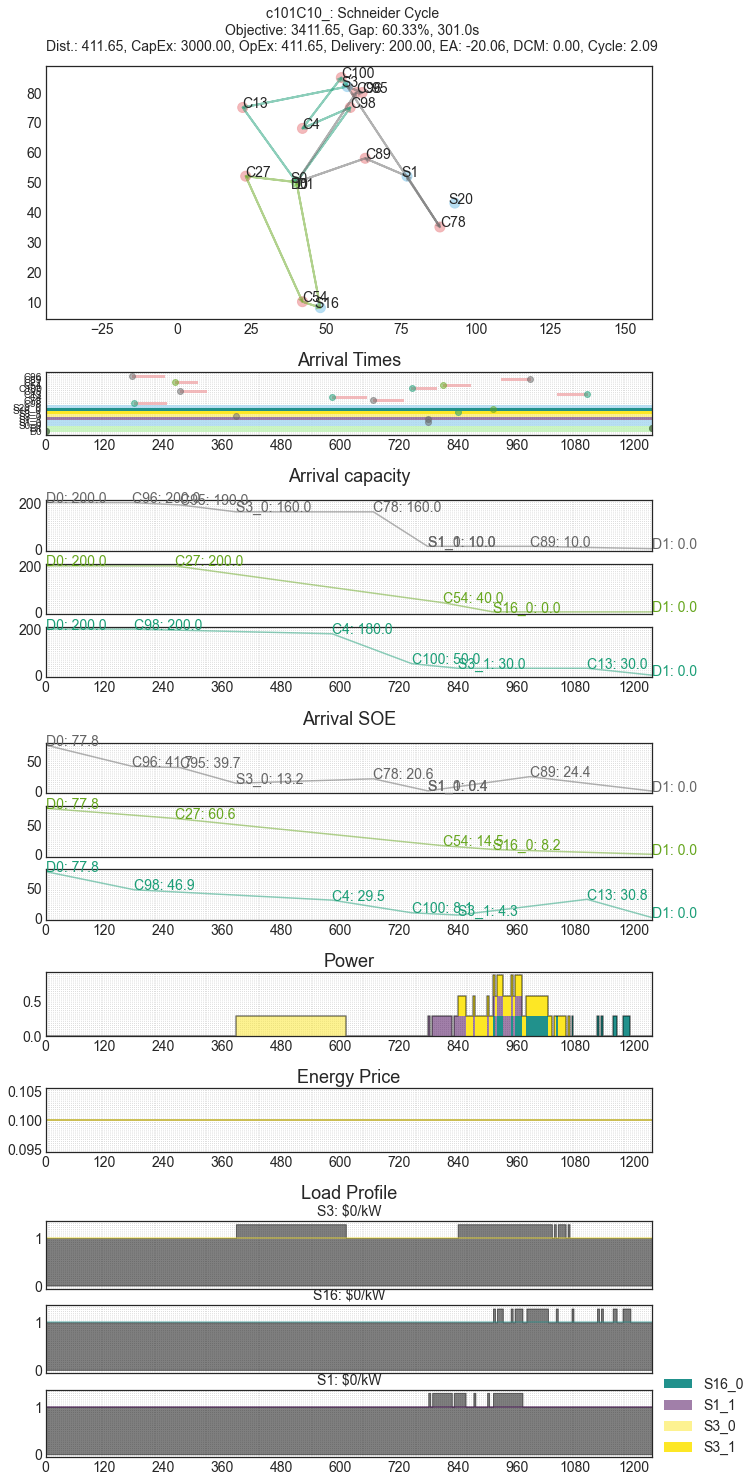

In [63]:
x, xp, traces, routes = plot_evrptwv2g(m, save=True)

In [56]:
routes

state           xw     xq         xa
from  to                                         
D0    D0       NaN     0.000000  200.0  77.750000
      C98      1.0   181.000000  170.0  46.090341
      C96      1.0   182.000000  200.0  41.396084
      C27      1.0   263.000000  200.0  18.059212
C96   C95      1.0   274.000000  190.0  39.396084
C98   S1_0     1.0   300.832868   60.0  16.257474
C27   S0_0     1.0   396.000000  190.0   0.941969
S1_0  S20_0    1.0   478.357560   60.0   1.358127
S0_0  C4       1.0   654.110770  190.0  51.995464
S20_0 C78      1.0   725.433981   60.0  59.935673
C95   C100     1.0   744.000000   30.0  30.793759
C100  S3_0     1.0   837.605551   10.0  27.188208
C78   C54      1.0   868.000000   40.0   7.581113
C54   S16_0    1.0   968.000000    0.0   1.256558
S3_0  C89      1.0   988.738634   10.0  24.351591
C4    C13      1.0  1106.000000   30.0  30.805844
C89   D1       1.0  1236.000000    0.0   0.000000
C13   D1       1.0  1236.000000    0.0   0.000000
S16_0 D1       1.0  1236.000000    0.0   0.000000

In [57]:
m.data['d']

,D0,D1,S0_0,S1_0,S3_0,S16_0,S20_0,C98,C78,C4,C13,C95,C100,C54,C27,C89,C96
D0,0.000000,0.000000,0.000000,37.054015,36.235342,42.755117,53.460266,30.805844,50.289164,18.110770,30.805844,37.202150,38.078866,40.049969,17.117243,24.351591,36.055513
D1,0.000000,0.000000,0.000000,37.054015,36.235342,42.755117,53.460266,30.805844,50.289164,18.110770,30.805844,37.202150,38.078866,40.049969,17.117243,24.351591,36.055513
S0_0,0.000000,0.000000,0.000000,37.054015,36.235342,42.755117,53.460266,30.805844,50.289164,18.110770,30.805844,37.202150,38.078866,40.049969,17.117243,24.351591,36.055513
S1_0,37.054015,37.054015,37.054015,0.000000,36.055513,52.697249,18.357560,29.832868,20.248457,38.483763,59.615434,31.764760,39.661064,54.671748,54.000000,15.231546,32.756679
S3_0,36.235342,36.235342,36.235342,36.055513,0.000000,74.545288,53.075418,7.071068,56.302753,20.518285,35.693137,5.385165,3.605551,73.545904,45.343136,24.738634,3.605551
S16_0,42.755117,42.755117,42.755117,52.697249,74.545288,0.000000,57.008771,67.742158,48.259714,60.299254,71.867934,73.348483,77.317527,6.324555,50.606324,52.201533,72.993150
S20_0,53.460266,53.460266,53.460266,18.357560,53.075418,57.008771,0.000000,47.423623,9.433981,56.797887,77.878110,48.270074,56.639209,60.745370,70.576200,33.541020,49.578221
C98,30.805844,30.805844,30.805844,29.832868,7.071068,67.742158,47.423623,0.000000,50.000000,17.464249,36.000000,6.403124,10.440307,66.940272,41.880783,17.720045,5.385165
C78,50.289164,50.289164,50.289164,20.248457,56.302753,48.259714,9.433981,50.000000,0.000000,56.612719,77.175126,51.971146,59.908263,52.354560,67.186308,33.970576,53.000000
C4,18.110770,18.110770,18.110770,38.483763,20.518285,60.299254,56.797887,17.464249,56.612719,0.000000,21.189620,23.323808,21.400935,58.000000,24.839485,23.259407,21.633308


# Archive, fix route, modify objective, and warmstart solve

In [ ]:
m.archive_instance_result()

In [ ]:
m.fix_variables(['xgamma'])

In [ ]:
m.remake_objective(m.instance, 'Opex Capex EA DCM cycle')

In [ ]:
m.warmstart_solve()

In [ ]:
print(m.results)

In [ ]:
x, xp, traces, routes = plot_evrptwv2g(m)

# Archive, rebuild model to modify constraints, fix route, warmstart solve

In [ ]:
m.archive_instance_result()

In [ ]:
m.instance_archive

In [ ]:
m.remake_model('Opex Capex EA DCM cycle wsplitxgamma', fpath)

In [ ]:
m.set_xgamma('Opex Capex EA DCM cycle')

In [ ]:
m.fix_variables(['xgamma'])

In [ ]:
m.make_solver(solve_options={'TimeLimit': 60 * 5})

In [ ]:
m.warmstart_solve()

In [ ]:
x, xp, traces, routes = plot_evrptwv2g(m)

In [ ]:
routes

# Check infeasible constraints

In [ ]:
from pyomo.util.infeasible import log_infeasible_constraints

In [ ]:
log_infeasible_constraints(m.instance)